# Lab — Travelling Salesman Problem solving via GNNs

In [1]:
!rm -r sample_data .config
!git clone https://github.com/netspractice/learning-tsp .

Cloning into '.'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 129 (delta 14), reused 0 (delta 0), pack-reused 95
Receiving objects: 100% (129/129), 54.36 MiB | 24.95 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [3]:
import requests
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import pandas as pd
from train import train_epoch
from nets.nar_model import NARModel
from nets.encoders.gnn_encoder import GNNEncoder
from utils import torch_load_cpu, load_problem
import warnings
warnings.filterwarnings('ignore')

Traveling Salesman Problem (TSP):
> *Given a set of cities and the distances between each pair of cities, what is the shortest possible tour that visits each city exactly once, and returns to the starting city?*

TSP is NP-hard problem

<table>
<tr><th>n <th>brute force<th>Held-Karp algorithm
<tr><td>  <td>expected time &approx; O(n!)<td>expected time &approx; O(n<sup>2</sup> 2<sup>n</sup>)
<tr><td>10<td> 10! tours = 2 secs                <td>0.1 secs 
<tr><td>11<td>2 secs &times; 11! / 10! &approx; 22 secs  <td>0.2 secs
<tr><td>12<td>2 secs &times; 12! / 10! &approx; 4 mins   <td>0.4 secs
<tr><td>14<td>2 secs &times; 14! / 10! &approx; 13 hours <td>3 secs
<tr><td>16<td>2 secs &times; 16! / 10! &approx; 200 days <td> 16<sup>2</sup> 2<sup>16</sup> tours = 11 secs
<tr><td>18<td>2 secs &times; 18! / 10! &approx; 112 years
<td>11 secs &times; (18/16)<sup>2</sup> 2<sup>(18-16)</sup> &approx; 1 min
<tr><td>25<td>2 secs &times; 25! / 10! &approx; 270 billion years
<td> 11 secs &times; (25/16)<sup>2</sup> 2<sup>(25-16)</sup>  &approx; 4 hours
<tr><td>50<td>2 secs &times; 50! / 10! &approx; 5 &times; 10<sup>50</sup> years</a><td>11 secs &times;  (50/16)<sup>2</sup> 2<sup>(50-16)</sup> &approx; 58,000 years
</table>

source: http://www.math.uwaterloo.ca/tsp/index.html

### Heuristic solution

Generate the data

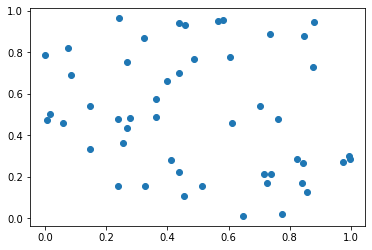

In [4]:
n_cities = 50
data = np.random.rand(n_cities, 2)
plt.scatter(data[:, 0], data[:, 1]);

Prepare distance matrix

In [6]:
dist_matrix = squareform(pdist(data))
dist_matrix[range(n_cities), range(n_cities)] = np.inf
pd.DataFrame(dist_matrix).iloc[:10, :10].round(2)

,0,1,2,3,4,5,6,7,8,9
0,inf,0.28,0.28,0.65,0.75,0.77,0.39,0.13,0.41,0.10
1,0.28,inf,0.45,0.38,0.52,0.62,0.51,0.34,0.57,0.37
2,0.28,0.45,inf,0.76,0.76,0.68,0.13,0.39,0.13,0.21
3,0.65,0.38,0.76,inf,0.27,0.52,0.77,0.71,0.87,0.74
4,0.75,0.52,0.76,0.27,inf,0.28,0.72,0.84,0.83,0.81
5,0.77,0.62,0.68,0.52,0.28,inf,0.59,0.89,0.71,0.79
6,0.39,0.51,0.13,0.77,0.72,0.59,inf,0.51,0.11,0.34
7,0.13,0.34,0.39,0.71,0.84,0.89,0.51,inf,0.51,0.19
8,0.41,0.57,0.13,0.87,0.83,0.71,0.11,0.51,inf,0.33
9,0.10,0.37,0.21,0.74,0.81,0.79,0.34,0.19,0.33,inf


A random tour

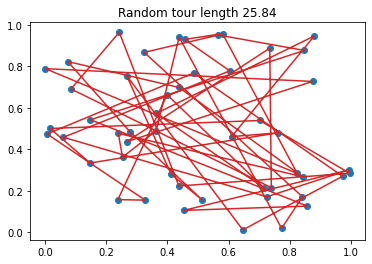

In [7]:
rtour = np.random.permutation(range(n_cities))
rtour = np.append(rtour, rtour[0])
row_id, col_id = rtour[:-1], rtour[1:]
plt.scatter(data[:, 0], data[:, 1])
plt.plot(data[rtour, 0], data[rtour, 1], c='tab:red')
plt.title(f'Random tour length {dist_matrix[row_id, col_id].sum():.2f}')
plt.show()

2-OPT heuristic

In [8]:
def twoopt(dist_matrix, tour, n_iter):
    best_length = dist_matrix[tour[:-1], tour[1:]].sum()
    best_tour = tour.copy()
    for _ in range(n_iter):
        for i in range(1, len(tour) - 2):
            for j in range(i + 1, len(tour) - 1):
                new_tour = np.concatenate([
                    best_tour[0:i],
                    best_tour[j:-len(tour) + i - 1:-1],
                    best_tour[j + 1:len(tour)]
                ])
                new_length = dist_matrix[new_tour[:-1], new_tour[1:]].sum()
                if new_length < best_length:
                    best_tour = new_tour
                    best_length = new_length
    return best_tour[:-1], best_tour[1:]

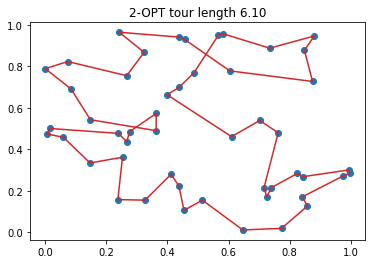

In [9]:
rtour = np.random.permutation(range(n_cities))
rtour = np.append(rtour, rtour[0])
row_id, col_id = twoopt(dist_matrix, rtour, n_iter=2)
tour = np.append(row_id, row_id[0])
plt.scatter(data[:, 0], data[:, 1])
plt.plot(data[tour, 0], data[tour, 1], c='tab:red')
plt.title(f'2-OPT tour length {dist_matrix[row_id, col_id].sum():.2f}')
plt.show()

Nearest neighbor (NN) heuristic

In [14]:
def nn(dist_matrix):
    best_length = np.inf
    best_tour = None
    for start_city in range(dist_matrix.shape[0]):
        copy_cost = dist_matrix.copy()
        current_city = start_city
        copy_cost[:, current_city] = np.inf
        tour = [current_city]
        for _ in range(copy_cost.shape[0]-1):
            next_city = np.argmin(copy_cost[current_city])
            tour.append(next_city)
            copy_cost[:, next_city] = np.inf
            current_city = next_city
        tour = np.array(tour + [tour[0]])
        new_length = dist_matrix[tour[:-1], tour[1:]].sum()
        if new_length < best_length:
                    best_tour = tour
                    best_length = new_length
    return best_tour[:-1], best_tour[1:]

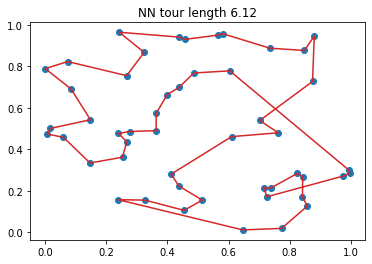

In [15]:
row_id, col_id = nn(dist_matrix)
tour = np.append(row_id, row_id[0])
plt.scatter(data[:, 0], data[:, 1])
plt.plot(data[tour, 0], data[tour, 1], c='tab:red')
plt.title(f'NN tour length {dist_matrix[row_id, col_id].sum():.2f}')
plt.show()

Stochastic NN + 2-OPT heuristic 

In [17]:
def stochastic_nn_2opt(dist_matrix, n_iter):
    row_id, col_id = nn(dist_matrix)
    nntour = np.append(row_id, row_id[0])
    row_id, col_id = twoopt(dist_matrix, nntour, n_iter=n_iter)
    new_tour = np.append(row_id, row_id[0])
    return new_tour[:-1], new_tour[1:]

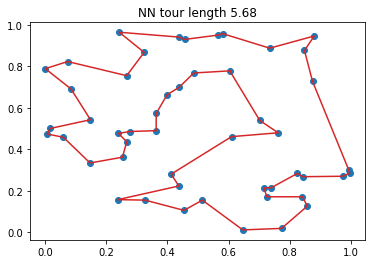

In [18]:
row_id, col_id = stochastic_nn_2opt(dist_matrix, n_iter=5)
tour = np.append(row_id, row_id[0])
plt.scatter(data[:, 0], data[:, 1])
plt.plot(data[tour, 0], data[tour, 1], c='tab:red')
plt.title(f'NN tour length {dist_matrix[row_id, col_id].sum():.2f}')
plt.show()

There are other heuristics: Insertion Heuristic (IH), Minimum Spanning Tree completion, etc.

### GNN model

* original paper: https://arxiv.org/abs/2006.07054
* source code: https://github.com/chaitjo/learning-tsp

The idea is to generate many instances and train GNN model to predict edges in the tour. The first step is to prepare graph.

<img src='https://github.com/netspractice/advanced_gnn/raw/main/lab_combinatorial_opt/gnn1.png' width=600>

Next, we create node embeddings

<img src='https://github.com/netspractice/advanced_gnn/raw/main/lab_combinatorial_opt/gnn2.png' width=600>

Finally, we decode embeddings into probabilities of presence of an edge in the optimal tour and then search a tour using greed search or beam search.

<img src='https://github.com/netspractice/advanced_gnn/raw/main/lab_combinatorial_opt/gnn3.png' width=600>

Encoder is defined as
$$
\begin{aligned}
h_{i}^{\ell+1} &=h_{i}^{\ell}+\operatorname{ReLU}\left(\operatorname{NORM}\left(U^{\ell} h_{i}^{\ell}+\operatorname{AGGR}_{j \in \mathcal{N}_{i}}\left(\sigma\left(e_{i j}^{\ell}\right) \odot V^{\ell} h_{j}^{\ell}\right)\right)\right) \\
e_{i j}^{\ell+1} &=e_{i j}^{\ell}+\operatorname{ReLU}\left(\operatorname{NORM}\left(A^{\ell} e_{i j}^{\ell}+B^{\ell} h_{i}^{\ell}+C^{\ell} h_{j}^{\ell}\right)\right)
\end{aligned}
$$

Decoder is defined as 
$$
\hat{p}_{i j}=W_{2}\left(\operatorname{ReLU}\left(W_{1}\left(\left[h_{G}, h_{i}^{L}, h_{j}^{L}\right]\right)\right)\right), \text { where } h_{G}=\frac{1}{n} \sum_{i=0}^{n} h_{i}^{L},
$$

Training is performed as in link prediction setting: minimization cross entropy between adjacency matrices.

Download dataset

In [19]:
url = 'https://github.com/netspractice/advanced_gnn/raw/main/lab_combinatorial_opt/tsp20-50_train_concorde.txt'
open('data/tsp/tsp20-50_train_concorde.txt', 'wb').write(requests.get(url).content)
url = 'https://github.com/netspractice/advanced_gnn/raw/main/lab_combinatorial_opt/tsp20_test_concorde.txt'
open('data/tsp/tsp20_test_concorde.txt', 'wb').write(requests.get(url).content)
url = 'https://github.com/netspractice/advanced_gnn/raw/main/lab_combinatorial_opt/tsp50_test_concorde.txt'
open('data/tsp/tsp50_test_concorde.txt', 'wb').write(requests.get(url).content);

In [20]:
problem = load_problem('tspsl')
train_dataset = problem.make_dataset(
        filename='data/tsp/tsp20-50_train_concorde.txt', batch_size=128, num_samples=12800, 
        neighbors=0.2, knn_strat='percentage', supervised=True, nar=True
    )
val_datasets = []
for val_filename in ['data/tsp/tsp20_test_concorde.txt', 'data/tsp/tsp50_test_concorde.txt']:
    val_datasets.append(
        problem.make_dataset(
            filename=val_filename, batch_size=128, num_samples=1280, 
            neighbors=0.2, knn_strat='percentage', supervised=True, nar=False
        ))


Loading from data/tsp/tsp20-50_train_concorde.txt...


100%|##########| 12800/12800 [00:01<00:00, 9186.41it/s]



Loading from data/tsp/tsp20_test_concorde.txt...


100%|##########| 1280/1280 [00:00<00:00, 24902.52it/s]



Loading from data/tsp/tsp50_test_concorde.txt...


100%|##########| 1280/1280 [00:00<00:00, 9932.43it/s] 


In [21]:
train_example = train_dataset[0]
train_example

{'graph': tensor([[1, 0, 1,  ..., 1, 1, 0],
         [0, 1, 1,  ..., 0, 1, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 0, 1,  ..., 1, 1, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [0, 0, 1,  ..., 0, 1, 1]], dtype=torch.uint8),
 'nodes': tensor([[0.4977, 0.8178],
         [0.6121, 0.7714],
         [0.8607, 0.1506],
         [0.1985, 0.8152],
         [0.1588, 0.1161],
         [0.0129, 0.4868],
         [0.3310, 0.8026],
         [0.0983, 0.0560],
         [0.4427, 0.0221],
         [0.2907, 0.2464],
         [0.7383, 0.8892],
         [0.9871, 0.1174],
         [0.3938, 0.4527],
         [0.5381, 0.7906],
         [0.4658, 0.4353],
         [0.5695, 0.9693],
         [0.0406, 0.5481],
         [0.4626, 0.3765],
         [0.3279, 0.8135],
         [0.6466, 0.0474],
         [0.9950, 0.6892],
         [0.9295, 0.9181],
         [0.9753, 0.3970],
         [0.2626, 0.4302],
         [0.7645, 0.5997],
         [0.0809, 0.7045],
         [0.1640, 0.0323],
        

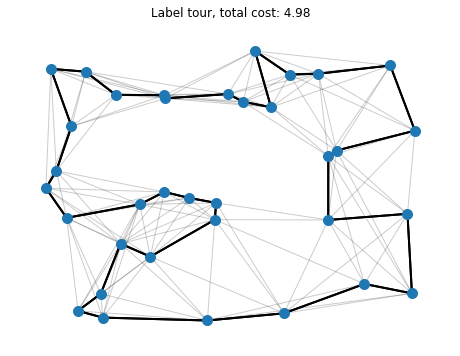

In [22]:
dist_matrix = squareform(pdist(train_example['nodes'].numpy()))
G = nx.from_numpy_array(1-train_example['graph'].numpy())
G.remove_edges_from(nx.selfloop_edges(G))
pos = {i: coord.numpy() for i, coord in enumerate(train_example['nodes'])}
tour = train_example['tour_edges'].nonzero().numpy()
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=tour, )
tour = train_example['tour_nodes'].numpy()
tour = np.append(tour, tour[0])
cost = dist_matrix[tour[:-1], tour[1:]].sum()
plt.title(f'Label tour, total cost: {cost:.2f}')
plt.axis('off')
plt.show()

Define the model

In [23]:
model = NARModel(
    problem=problem,
    embedding_dim=128,
    encoder_class=GNNEncoder,
    n_encode_layers=2,
    aggregation='max',
    aggregation_graph='mean',
    normalization='batch',
)
model.to('cuda')

NARModel(
  (init_embed): Linear(in_features=2, out_features=128, bias=True)
  (embedder): GNNEncoder(
    (init_embed_edges): Embedding(2, 128)
    (layers): ModuleList(
      (0): GNNLayer(
        (U): Linear(in_features=128, out_features=128, bias=True)
        (V): Linear(in_features=128, out_features=128, bias=True)
        (A): Linear(in_features=128, out_features=128, bias=True)
        (B): Linear(in_features=128, out_features=128, bias=True)
        (C): Linear(in_features=128, out_features=128, bias=True)
        (norm_h): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (norm_e): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      )
      (1): GNNLayer(
        (U): Linear(in_features=128, out_features=128, bias=True)
        (V): Linear(in_features=128, out_features=128, bias=True)
        (A): Linear(in_features=128, out_features=128, bias=True)
        (B): Linear(in_features=128, out_features=1

In [24]:
optimizer = optim.Adam(params=model.parameters(), lr=0.0005)

Run the training

In [25]:
class option():
    def __init__(self):
        self.run_name = 'train'
        self.epoch_size = 12800
        self.batch_size = 128
        self.no_tensorboard = True
        self.num_workers = 1
        self.no_progress_bar = False
        self.device = 'cuda'
        self.model = 'nar'
        self.accumulation_steps = 8
        self.max_grad_norm = 1
        self.log_step = 100
        self.checkpoint_epochs = 0
        self.n_epochs = 10
        self.save_dir = ""
opt = option()

for epoch in range(opt.n_epochs):
    train_epoch_sl(
        model,
        optimizer,
        optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 1.0 ** epoch),
        epoch,
        train_dataset,
        val_datasets,
        problem,
        None,
        opt
    )


Start train epoch 0, lr=0.0005 for run train


  2%|2         | 2/100 [00:00<00:32,  2.99it/s]


epoch: 0, train_batch_id: 0, loss: 0.09267475455999374, avg_cost: 0.0
grad_norm: 0.3079821467399597, clipped: 0.3079821467399597


100%|##########| 100/100 [00:18<00:00,  5.55it/s]


Finished epoch 0, took 00:00:18 s

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 16.61it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.676 +- 0.510
Validation optimality gap: 21.621% +- 10.068

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:01<00:00,  6.96it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 8.130 +- 0.550
Validation optimality gap: 42.996% +- 8.381

Start train epoch 1, lr=0.0005 for run train


  1%|1         | 1/100 [00:00<00:16,  5.97it/s]


epoch: 1, train_batch_id: 0, loss: 0.06833507120609283, avg_cost: 0.0
grad_norm: 0.04053381085395813, clipped: 0.04053381085395813


100%|##########| 100/100 [00:19<00:00,  5.25it/s]


Finished epoch 1, took 00:00:19 s

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 16.47it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.488 +- 0.468
Validation optimality gap: 16.692% +- 8.594

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:01<00:00,  6.97it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 7.606 +- 0.489
Validation optimality gap: 33.801% +- 7.690

Start train epoch 2, lr=0.0005 for run train


  1%|1         | 1/100 [00:00<00:18,  5.48it/s]


epoch: 2, train_batch_id: 0, loss: 0.05983515456318855, avg_cost: 0.0
grad_norm: 0.03712642565369606, clipped: 0.03712642565369606


100%|##########| 100/100 [00:17<00:00,  5.66it/s]


Finished epoch 2, took 00:00:17 s

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 16.14it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.413 +- 0.454
Validation optimality gap: 14.751% +- 8.002

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:01<00:00,  7.04it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 7.595 +- 0.552
Validation optimality gap: 33.586% +- 8.432

Start train epoch 3, lr=0.0005 for run train


  2%|2         | 2/100 [00:00<00:18,  5.28it/s]


epoch: 3, train_batch_id: 0, loss: 0.05348833650350571, avg_cost: 0.0
grad_norm: 0.04385377839207649, clipped: 0.04385377839207649


100%|##########| 100/100 [00:18<00:00,  5.51it/s]


Finished epoch 3, took 00:00:18 s

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 16.61it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.377 +- 0.451
Validation optimality gap: 13.798% +- 7.934

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:01<00:00,  7.01it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 7.548 +- 0.568
Validation optimality gap: 32.739% +- 8.531

Start train epoch 4, lr=0.0005 for run train


  1%|1         | 1/100 [00:00<00:27,  3.60it/s]


epoch: 4, train_batch_id: 0, loss: 0.04826120659708977, avg_cost: 0.0
grad_norm: 0.04235538840293884, clipped: 0.04235538840293884


100%|##########| 100/100 [00:17<00:00,  5.68it/s]


Finished epoch 4, took 00:00:17 s

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 15.56it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.351 +- 0.446
Validation optimality gap: 13.136% +- 7.929

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:01<00:00,  7.02it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 7.474 +- 0.535
Validation optimality gap: 31.435% +- 7.878

Start train epoch 5, lr=0.0005 for run train


  1%|1         | 1/100 [00:00<00:19,  5.05it/s]


epoch: 5, train_batch_id: 0, loss: 0.04710743576288223, avg_cost: 0.0
grad_norm: 0.10428059101104736, clipped: 0.10428059101104736


100%|##########| 100/100 [00:18<00:00,  5.51it/s]


Finished epoch 5, took 00:00:18 s

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 15.46it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.314 +- 0.441
Validation optimality gap: 12.174% +- 7.634

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:01<00:00,  7.02it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 7.241 +- 0.523
Validation optimality gap: 27.331% +- 7.624

Start train epoch 6, lr=0.0005 for run train


  1%|1         | 1/100 [00:00<00:47,  2.07it/s]


epoch: 6, train_batch_id: 0, loss: 0.041047777980566025, avg_cost: 0.0
grad_norm: 0.02582819014787674, clipped: 0.02582819014787674


100%|##########| 100/100 [00:18<00:00,  5.52it/s]


Finished epoch 6, took 00:00:18 s

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 15.94it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.307 +- 0.448
Validation optimality gap: 11.961% +- 7.780

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:01<00:00,  6.87it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 7.145 +- 0.505
Validation optimality gap: 25.649% +- 7.508

Start train epoch 7, lr=0.0005 for run train


  0%|          | 0/100 [00:00<?, ?it/s]


epoch: 7, train_batch_id: 0, loss: 0.046700600534677505, avg_cost: 0.0

  1%|1         | 1/100 [00:00<00:19,  5.04it/s]


grad_norm: 0.3014906644821167, clipped: 0.3014906644821167


100%|##########| 100/100 [00:18<00:00,  5.54it/s]


Finished epoch 7, took 00:00:18 s

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 16.31it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.292 +- 0.442
Validation optimality gap: 11.571% +- 7.524

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:01<00:00,  7.07it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 7.057 +- 0.487
Validation optimality gap: 24.115% +- 7.144

Start train epoch 8, lr=0.0005 for run train


  3%|3         | 3/100 [00:00<00:13,  7.18it/s]


epoch: 8, train_batch_id: 0, loss: 0.03886225447058678, avg_cost: 0.0
grad_norm: 0.03314542397856712, clipped: 0.03314542397856712


100%|##########| 100/100 [00:17<00:00,  5.63it/s]


Finished epoch 8, took 00:00:17 s

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 16.57it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.284 +- 0.438
Validation optimality gap: 11.374% +- 7.462

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:01<00:00,  7.12it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 7.000 +- 0.486
Validation optimality gap: 23.108% +- 7.081

Start train epoch 9, lr=0.0005 for run train


  1%|1         | 1/100 [00:00<00:18,  5.49it/s]


epoch: 9, train_batch_id: 0, loss: 0.042642008513212204, avg_cost: 0.0
grad_norm: 0.027619430795311928, clipped: 0.027619430795311928


100%|##########| 100/100 [00:17<00:00,  5.59it/s]


Finished epoch 9, took 00:00:17 s
Saving model and state...

Validating on 1280 samples from data/tsp/tsp20_test_concorde.txt...


100%|##########| 10/10 [00:00<00:00, 16.39it/s]


Validation groundtruth cost: 3.847 +- 0.308
Validation average cost: 4.285 +- 0.446
Validation optimality gap: 11.370% +- 7.503

Validating on 1280 samples from data/tsp/tsp50_test_concorde.txt...


100%|##########| 10/10 [00:01<00:00,  6.97it/s]


Validation groundtruth cost: 5.688 +- 0.255
Validation average cost: 7.002 +- 0.492
Validation optimality gap: 23.133% +- 6.992


Test the model and visualize a tour on a test example

In [34]:
test_example = val_datasets[0][6]
dist_matrix = squareform(pdist(test_example['nodes'].numpy()))
dist_matrix[(range(dist_matrix.shape[0])), (range(dist_matrix.shape[0]))] = np.inf

Create node embeddings

In [35]:
nodes = test_example['nodes'][None, ...].to('cuda')
graph = test_example['graph'][None, ...].to('cuda')
model.eval()
with torch.no_grad():
    embeddings = model.embedder(model._init_embed(nodes), graph)
embeddings.shape

torch.Size([1, 20, 128])

Create edge embeddings

In [36]:
with torch.no_grad():
    Ux = model.project_node_emb(embeddings)
    Gx = model.project_graph_emb(embeddings.mean(dim=1))
edge_embeddings = F.relu(Ux[:, :, None, :] + Ux[:, None, :, :] + Gx[:, None, None, :])

if model.mask_graph:
    edge_embeddings[graph[:, :, :, None].expand_as(edge_embeddings)] = 0

# Compute logits
with torch.no_grad():
    logits = model.edge_pred(edge_embeddings)  # B x V x V x 2
proba = F.softmax(logits, dim=3)
proba_adj = proba[0, :, :, 1].cpu().numpy()
proba_adj.shape

(20, 20)

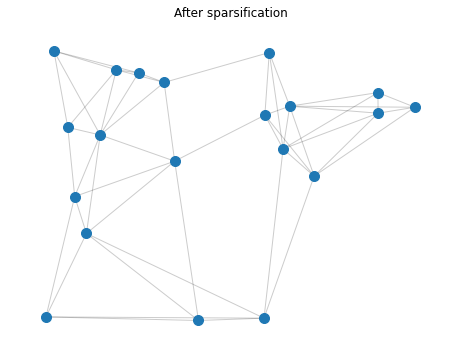

In [39]:
G = nx.from_numpy_array(1-test_example['graph'].numpy())
G.remove_edges_from(nx.selfloop_edges(G))
pos = {i: coord.numpy() for i, coord in enumerate(test_example['nodes'])}
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
plt.title('After sparsification')
plt.axis('off')
plt.show()

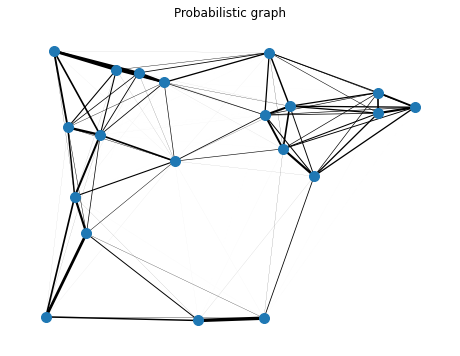

In [41]:
G = nx.from_numpy_array(proba_adj)
G.remove_edges_from(nx.selfloop_edges(G))
pos = {i: coord.numpy() for i, coord in enumerate(test_example['nodes'])}
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, width=[(G[u][v]['weight']*2)**2 for u,v in G.edges])
plt.title('Probabilistic graph')
plt.axis('off')
plt.show()

Generate a tour

In [77]:
with torch.no_grad():
    _, _, tour = model.forward(nodes, graph, return_pi=True)
tour = tour.cpu().numpy()[0]
tour = np.append(tour, tour[0])
tour

array([ 0,  2, 19,  1,  3,  4,  8, 11,  5, 17, 10,  7,  9, 13, 14, 18, 12,
        6, 16, 15,  0])

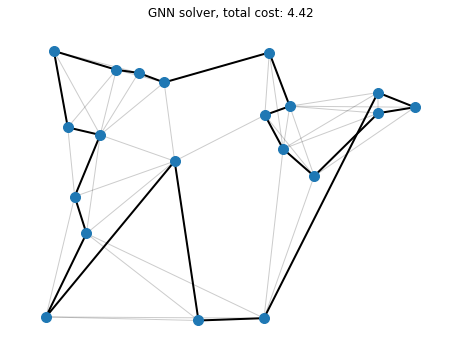

In [78]:
G = nx.from_numpy_array(1-test_example['graph'].numpy())
G.remove_edges_from(nx.selfloop_edges(G))
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([tour[:-1], tour[1:]], axis=1))
cost = dist_matrix[tour[:-1], tour[1:]].sum()
plt.title(f'GNN solver, total cost: {cost:.2f}')
plt.axis('off')
plt.show()

Also check NN heuristic

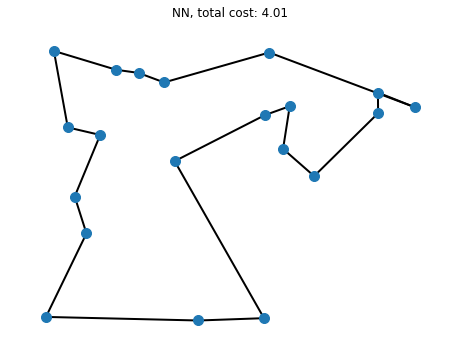

In [69]:
row_id, col_id = nn(dist_matrix)
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([row_id, col_id], axis=1), )
cost = dist_matrix[row_id, col_id].sum()
plt.title(f'NN, total cost: {cost:.2f}')
plt.axis('off')
plt.show()

2-OPT

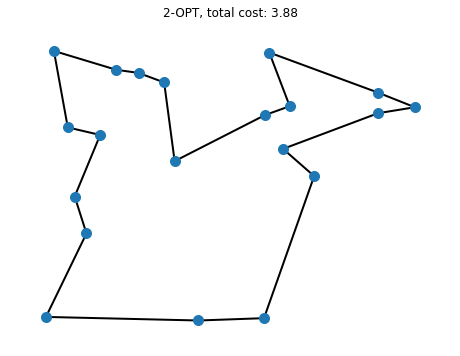

In [70]:
rtour = np.random.permutation(range(dist_matrix.shape[0]))
rtour = np.append(rtour, rtour[0])
row_id, col_id = twoopt(dist_matrix, rtour, n_iter=2)
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([row_id, col_id], axis=1), )
cost = dist_matrix[row_id, col_id].sum()
plt.title(f'2-OPT, total cost: {cost:.2f}')
plt.axis('off')
plt.show()

Stochastic NN + 2-OPT

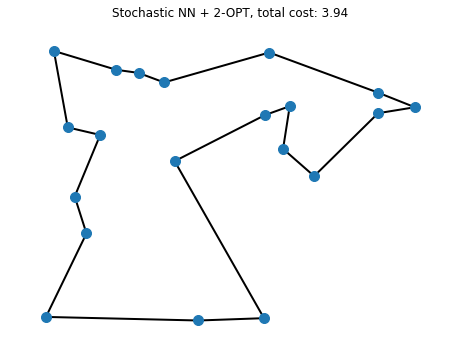

In [72]:
row_id, col_id = stochastic_nn_2opt(dist_matrix, n_iter=5)
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos, width=2, edgelist=np.stack([row_id, col_id], axis=1), )
cost = dist_matrix[row_id, col_id].sum()
plt.title(f'Stochastic NN + 2-OPT, total cost: {cost:.2f}')
plt.axis('off')
plt.show()